C:\Users\jckri\AppData\Local\Temp\ipykernel_19496\898451973.py:19: RuntimeWarning: invalid value encountered in sqrt
  self.tablePrandtlMeyerValue = np.sqrt((self.gamma+1)/(self.gamma-1)) * np.arctan( np.sqrt( (self.gamma-1)*(np.square(self.tableMachs)-1)/(self.gamma+1) ) ) - np.arctan( np.sqrt( np.square(self.tableMachs) - 1 ) )


Nu = 37.56045523620555 deg
Mu = 20.17127134646498 deg


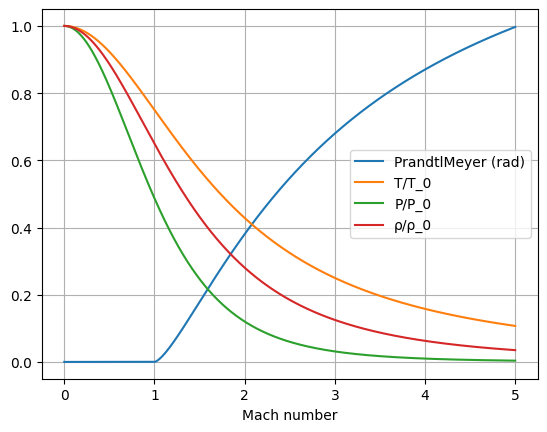

In [1]:
import numpy as np
import matplotlib.pyplot as plot 
import math

MACHRESOLUTION = 0.0001

class IsentropicFlowTable:
    def __init__(self, gamma, maxMach, machResolution=MACHRESOLUTION):
        self.maxMach = maxMach
        self.gamma = gamma
        self.machResolution = machResolution 
        self.genTable();

    def genTable(self):
        # generate the input machs into the table
        self.tableMachs = np.arange( 0, self.maxMach+self.machResolution, self.machResolution )

        # Generate Prandtl-Meyer angles for each Ma
        self.tablePrandtlMeyerValue = np.sqrt((self.gamma+1)/(self.gamma-1)) * np.arctan( np.sqrt( (self.gamma-1)*(np.square(self.tableMachs)-1)/(self.gamma+1) ) ) - np.arctan( np.sqrt( np.square(self.tableMachs) - 1 ) )
        # Nan filter to fix interpolation bug near Ma=1
        self.tablePrandtlMeyerValue = np.nan_to_num(self.tablePrandtlMeyerValue, nan=0)

        # Other table values
        self.tableT_overT0 = 1/(1 + (self.gamma-1)*(np.square(self.tableMachs))/2)
        self.tableP_overP0 = np.power( 1/(self.tableT_overT0), - self.gamma/(self.gamma-1) )
        self.tableRho_overRho0 = np.power( 1/(self.tableT_overT0), - 1/(self.gamma-1) )
        
    def getMachAtNu(self, nu):
        return np.interp( nu, self.tablePrandtlMeyerValue, self.tableMachs )
        
    def getNuAtMach(self, mach):
        return np.interp( mach, self.tableMachs, self.tablePrandtlMeyerValue )

    def showIFTGraph(self):
        plot.figure(87443452)
        plot.grid()
    
        #plot.title("AOA against Lift coefficient for NACA0020 finite wing" ) 
        #plot.ylabel( "lift coefficient (CL)" )
        plot.xlabel( "Mach number" )  
    
        plot.plot( self.tableMachs, (self.tablePrandtlMeyerValue), label="PrandtlMeyer (rad)" ) 
        plot.plot( self.tableMachs, self.tableT_overT0, label="T/T_0" ) 
        plot.plot( self.tableMachs, self.tableP_overP0, label="P/P_0" ) 
        plot.plot( self.tableMachs, self.tableRho_overRho0, label="ρ/ρ_0" ) 
     
        plot.legend()
        plot.show()

airIFT = IsentropicFlowTable( 5/3, 5 )
print( "Nu =", np.rad2deg(airIFT.getNuAtMach( 2.9 )),"deg" )
print( "Mu =", np.rad2deg( np.arcsin(1/2.9) ),"deg" ) 
airIFT.showIFTGraph()        


That defines the Isentropic flow table, poggers I guess.




C:\Users\jckri\AppData\Local\Temp\ipykernel_19496\898451973.py:19: RuntimeWarning: invalid value encountered in sqrt
  self.tablePrandtlMeyerValue = np.sqrt((self.gamma+1)/(self.gamma-1)) * np.arctan( np.sqrt( (self.gamma-1)*(np.square(self.tableMachs)-1)/(self.gamma+1) ) ) - np.arctan( np.sqrt( np.square(self.tableMachs) - 1 ) )


[1.00009967 1.0547556  1.1519147  1.2909769  1.48271854 1.74618182
 1.74618182]
[1.0115721  1.29225919 1.50632556 1.721235   1.94955026 2.2
 2.2       ]


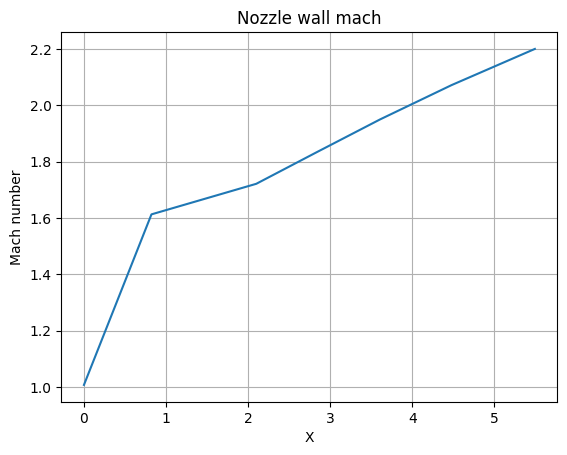

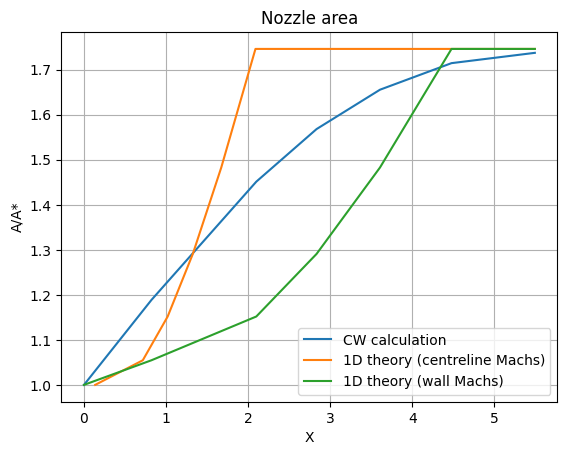

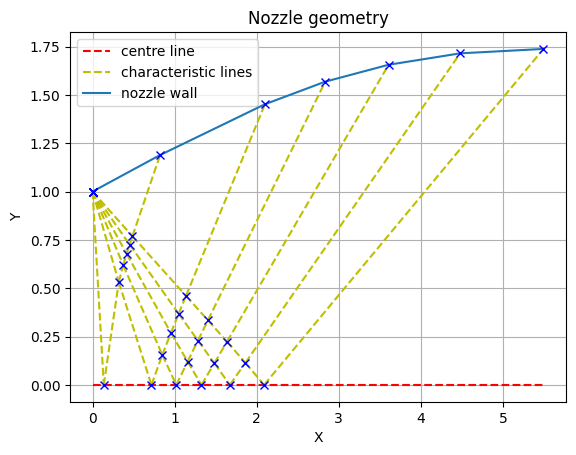

In [5]:

DEFAULT_LINE_COUNT = 4

def triangularNumber( n ):
    return round((n*(n+1)/2))

def formatInp( inp, convAng=False ):  
    oup = 0
    if ( convAng ): 
        oup = str( round( (180/3.14159265358979323846264338327)*(inp) * 100000 )/100000  )
    else:
        oup = str( round( inp * 100000 )/100000  )

    while (len(oup) < 8):
        oup += " "
    if (len(oup) > 8):
        oup = oup[0:8]

    return " | "+oup
    

class NozzleDesigner:  
    def __init__(self, targetMach, IFT=IsentropicFlowTable(1.4,10), fanLines=DEFAULT_LINE_COUNT, minAngleDeg=0.37):
        self.fanLines = fanLines
        self.gamma = IFT.gamma
        self.IFT = IFT
        self.targetMach = targetMach
        self.minAngleDeg = minAngleDeg
        
        self.solve()

    def solve(self):
        # curviture angle directly after throat
        self.thetaMax = self.IFT.getNuAtMach( self.targetMach )/2

        self.pointCount = triangularNumber( self.fanLines )+ self.fanLines*2
        
        self.pointX = [-1]*self.pointCount
        self.pointY = [-1]*self.pointCount
        self.pointReinInvPos = [-1]*self.pointCount
        self.pointReinInvNeg = [-1]*self.pointCount
        self.pointTheta = [-1]*self.pointCount
        self.pointNu = [-1]*self.pointCount
        self.pointMu = [-1]*self.pointCount
        self.pointMach = [-1]*self.pointCount
        self.alphaA = [-1]*self.pointCount
        self.alphaB = [-1]*self.pointCount
        self.prefA = [-1]*self.pointCount
        self.prefB = [-1]*self.pointCount
        self.wallPointIndexs = [0]
        self.centreLineIndexs = []
        
        self.ppIndx = [-1]*self.pointCount
        self.pnIndx = [-1]*self.pointCount
        self.pType  = [-1]*self.pointCount

        #startingAngle = np.deg2rad(0.37) # set to VERY near zero later
        startingAngle = np.deg2rad(self.minAngleDeg)
        
        # now we setup the fan lines
        for i in range(0, self.fanLines):
            # they have evenly spaced theta's
            self.pointTheta[i] = startingAngle + (i)*(self.thetaMax-startingAngle)/(self.fanLines-1) 
            self.pointNu[i] = self.pointTheta[i]
            self.pointX[i] = 0
            self.pointY[i] = 1

            self.findPointReinInvs( i )
            self.findPointProperties( i )

        prevFrontStartIndex = 0
        prevWallIndex = self.fanLines-1
        prevWallTheta = self.thetaMax
        # Then solve for the interception points
        for frontNumber in range(0, self.fanLines):

            frontPointCount = int(self.fanLines - frontNumber)
            
            # The starting index for the frontpoints assosiated with this front number
            frontStartIndex = self.fanLines +frontNumber+ triangularNumber( self.fanLines ) - triangularNumber( self.fanLines - frontNumber )
            #print("---------------------------------")
            #print(frontNumber, frontPointCount, frontStartIndex)
 

            # Finding point properties
            for i in range( 0, frontPointCount ):
                pointIndex = i + frontStartIndex
                
                # Find R-, trivial 
                self.pointReinInvNeg[pointIndex] = self.pointReinInvNeg[ i + frontNumber ]

                # Find R+, trivial
                self.pointReinInvPos[pointIndex] = self.pointReinInvNeg[ frontNumber ]

                # Find nu and theta
                self.pointNu[pointIndex] = (self.pointReinInvNeg[pointIndex] + self.pointReinInvPos[pointIndex])/2
                self.pointTheta[pointIndex] = (self.pointReinInvNeg[pointIndex] - self.pointReinInvPos[pointIndex])/2

                # Mach and nu
                self.findPointProperties( pointIndex )
                
                #print(pointIndex-3, "\t", np.rad2deg(self.pointReinInvPos[pointIndex]), np.rad2deg(self.pointReinInvNeg[pointIndex]), "\t",np.rad2deg(self.pointTheta[pointIndex] ), "\t",np.rad2deg(self.pointNu[pointIndex]))

            # Finding centre line point location 
            self.pointY[frontStartIndex] = 0  

            # Calculate the x-y positions of all other points on the front  
            pointBIndex = prevFrontStartIndex + 1
            if ( prevFrontStartIndex==0 ):
                pointBIndex -= 1
            
            # Takes a relevant point to be it's previous refrence point
            prevPointX = self.pointX[ pointBIndex ]
            prevPointY = self.pointY[ pointBIndex ]
            prevPointTheta = self.pointTheta[ pointBIndex ]
            prevPointMu = self.pointMu[ pointBIndex ]

            self.ppIndx[frontStartIndex] = pointBIndex
            self.pnIndx[frontStartIndex] = frontStartIndex
            self.pType[frontStartIndex]  = -1
            self.centreLineIndexs.append(frontStartIndex)

            # Approx angle from ref point to target, average ALPHA angle between point and refrance
            alpha_pvToN = ( ( prevPointTheta - prevPointMu ) + ( self.pointTheta[frontStartIndex] - self.pointMu[frontStartIndex] ) )/2

            self.pointX[frontStartIndex] = prevPointX - prevPointY/np.tan( alpha_pvToN ) 

            #print(frontStartIndex-3, self.pointX[frontStartIndex], np.rad2deg(alpha_pvToN))

            pointBIndex+=1
            pointAIndex = frontStartIndex; 
                
            for i in range(1, frontPointCount):
                pointPIndex = i + frontStartIndex
                
                alpha_AP = ( (self.pointTheta[pointAIndex] + self.pointMu[pointAIndex] ) + (self.pointTheta[pointPIndex] + self.pointMu[pointPIndex] ) )/2
                alpha_BP = ( (self.pointTheta[pointBIndex] - self.pointMu[pointBIndex] ) + (self.pointTheta[pointPIndex] - self.pointMu[pointPIndex] ) )/2

                #print( pointPIndex-3, pointAIndex-3, pointBIndex-3 )

                self.pointX[pointPIndex] = ( self.pointX[pointBIndex]*np.tan(alpha_BP) - self.pointX[pointAIndex]*np.tan(alpha_AP) + self.pointY[pointAIndex] - self.pointY[pointBIndex] )/(np.tan(alpha_BP)-np.tan(alpha_AP))
                self.pointY[pointPIndex] = self.pointY[pointAIndex] + (self.pointX[pointPIndex] - self.pointX[pointAIndex])*np.tan( alpha_AP )

                self.alphaA[ pointPIndex ] = alpha_AP
                self.alphaB[ pointPIndex ] = alpha_BP

                self.ppIndx[ pointPIndex ] = pointAIndex
                self.pnIndx[ pointPIndex ] = pointBIndex
                self.pType[ pointPIndex ]  = 1
                
                self.alphaA[ pointPIndex ] = alpha_AP
                self.alphaB[ pointPIndex ] = alpha_BP
                
                pointAIndex+=1
                pointBIndex+=1
            

            # Finally at the end it calculates the wall intercept point
            wallPointIndex = frontStartIndex + frontPointCount
            prevPointIndex = wallPointIndex - 1

            self.prefA[wallPointIndex] = prevPointIndex
            self.prefB[wallPointIndex] = prevWallIndex
            
            #print("wp", wallPointIndex - 3, prevWallIndex- 3, prevPointIndex - 3 )

            # for wave cancellation the flow angle at wall=flow angle of prev point, which leads to everything else also copying... since on same line 
            self.pointTheta[ wallPointIndex ] = self.pointTheta[ prevPointIndex ]
            self.pointNu[ wallPointIndex ] = self.pointNu[ prevPointIndex ]
            self.pointMu[ wallPointIndex ] = self.pointMu[ prevPointIndex ]
            self.pointMach[ wallPointIndex ] = self.pointMach[ prevPointIndex ]
            
            alpha_prPoint = (self.pointMu[ prevPointIndex ] + self.pointTheta[ prevPointIndex ])
            alpha_Wall = (self.pointTheta[ prevWallIndex ] + self.pointTheta[ wallPointIndex ])/2

            self.alphaA[ wallPointIndex ] = alpha_prPoint
            self.alphaB[ wallPointIndex ] = alpha_Wall

            #print("wallAlpha:",np.rad2deg(alpha_Wall), "   ppAlpha:",np.rad2deg(alpha_prPoint))

            self.pointX[wallPointIndex] = ( self.pointX[prevWallIndex]*np.tan(alpha_Wall) - self.pointX[prevPointIndex]*np.tan(alpha_prPoint) + self.pointY[prevPointIndex] - self.pointY[prevWallIndex] )/(np.tan(alpha_Wall)-np.tan(alpha_prPoint))
            self.pointY[wallPointIndex] = self.pointY[prevPointIndex] + (self.pointX[wallPointIndex] - self.pointX[prevPointIndex])*np.tan( alpha_prPoint )
            
            
            self.wallPointIndexs.append( wallPointIndex )

            self.ppIndx[ wallPointIndex ] = -1
            self.pnIndx[ wallPointIndex ] = prevPointIndex
            self.pType[ wallPointIndex ]  = 2
        
            prevWallIndex = wallPointIndex
            prevFrontStartIndex = frontStartIndex
            
                
                

    # Find R+ and R-
    def findPointReinInvs(self, index):
        self.pointReinInvPos[index] = self.pointNu[index] - self.pointTheta[index]
        self.pointReinInvNeg[index] = self.pointNu[index] + self.pointTheta[index]

    # Mach and nu
    def findPointProperties(self, index):
        self.pointMach[index] = self.IFT.getMachAtNu( self.pointNu[index] )
        self.pointMu[index] = float( np.arcsin(1/self.pointMach[index]) )
    
    def printTable(self):
        #print("i\tR+\tR-\ttheta\tnu\tM\tmu\tX\tY\talA\talB\tiA\tiB")
        #print("i\tR+\tR-\ttheta\tnu\tM\tmu\tthe+Mu\tthe-Mu\tX\tY")
        print("i \t | R+       | R-       | theta    | nu       | M        | Mu       | the+Mu   | the-Mu   | X        | Y        | Alpha A  | Alpha B  ")
        for i in range(0, self.pointCount): 
            line = ""

            line += str(i-self.fanLines+1) + "\t"; 
            line = line +  formatInp(self.pointReinInvPos[i], True) ;
            line = line +  formatInp(self.pointReinInvNeg [i], True) ;
            line = line +  formatInp(self.pointTheta[i], True)  ;
            line = line +  formatInp(self.pointNu[i], True)  ;
            line = line +  formatInp(self.pointMach[i]) ;
            line = line +  formatInp(self.pointMu[i], True)  ;
            line = line +  formatInp(self.pointTheta[i]+self.pointMu[i], True) ;
            line = line +  formatInp(self.pointTheta[i]-self.pointMu[i], True) ; 
            line = line +  formatInp(self.pointX[i])  
            line = line +  formatInp(self.pointY[i])  
            line = line +  formatInp(self.alphaA[i], True)  ;
            line = line +  formatInp(self.alphaB[i], True) ;
            #line = line +  formatInp(self.alphaA[i], True)  + "\t";
            #line = line +  formatInp(self.alphaB[i], True)  + "\t"; 
            #line = line +  formatInp(self.prefA[i]-self.fanLines+1)  + "\t"; 
            #line = line +  formatInp(self.prefB[i]-self.fanLines+1)  + "\t"; 
            
            print( line  )
        #print("i\tR+\tR-\ttheta\tnu\tM\tmu\tX\tY")

    def get1DError(self):
        centMach = self.pointMach[ len(self.pointMach)-1 ]
        centA = (1/centMach)*((2/(self.gamma+1)) * (1 + (self.gamma-1)*(centMach**2)/2) )**((self.gamma+1)/(2*(self.gamma-1)))

        return centA - self.pointY[len(self.pointMach)-1]

    def getPerc1DError(self):
        centMach = self.pointMach[ len(self.pointMach)-1 ]
        centA = (1/centMach)*((2/(self.gamma+1)) * (1 + (self.gamma-1)*(centMach**2)/2) )**((self.gamma+1)/(2*(self.gamma-1)))
        otheA = self.pointY[len(self.pointMach)-1]

        
        return abs((centA - otheA)*100/otheA)
    
    def makeGraphs(self):

        xPoints = []
        yPoints = []
        machs = []
        areaRs = []

        for wallIndex in self.wallPointIndexs: 
            xPoints.append( self.pointX[wallIndex] )
            yPoints.append( self.pointY[wallIndex] )
            machs.append( self.pointMach[wallIndex] )
            areaRs.append( self.pointY[wallIndex] )

        centMach = []
        centX = []
        for i in range(0, len(self.centreLineIndexs)):  
            centMach.append( self.pointMach[self.centreLineIndexs[i ]] ) 
            centX.append( self.pointX[self.centreLineIndexs[i]] )
            
        centMach.append( self.pointMach[ len(self.pointX)-1 ] ) 
        centX.append( self.pointX[ len(self.pointX)-1 ] )

        centMach = np.array(centMach)
        wallMach = np.array(machs)
        
        plot.figure(87442132)
        plot.grid() 
        plot.xlabel( "X" ) 
        plot.ylabel( "Mach number" )  
        plot.title("Nozzle wall mach")
        plot.plot( xPoints, machs )  
        
        
        plot.figure(8744213233)
        plot.grid() 
        plot.xlabel( "X" ) 
        plot.ylabel( "A/A*" )  
        plot.title("Nozzle area")
        plot.plot( xPoints, areaRs, label="CW calculation" )
        centA = (1/centMach)*((2/(self.gamma+1)) * (1 + (self.gamma-1)*(centMach**2)/2) )**((self.gamma+1)/(2*(self.gamma-1)))
        wallA = (1/wallMach)*((2/(self.gamma+1)) * (1 + (self.gamma-1)*(wallMach**2)/2) )**((self.gamma+1)/(2*(self.gamma-1)))
        plot.plot( centX, centA, label="1D theory (centreline Machs)" )
        plot.plot( xPoints, centA, label="1D theory (wall Machs)" )
        print(centA)
        print(centMach)
     
        plot.legend()
        
        
        plot.figure(287442132)
    
        plot.plot( [0,self.pointX[self.pointCount-1]], [0,0], "r--", label="centre line")  
        plot.plot( [0,0 ], [0,0], "y--", label="characteristic lines")
        
        for pointIndex in range(0, self.pointCount): 
            othIndx = self.ppIndx[ pointIndex ];
            if (othIndx != -1):
                plot.plot( [self.pointX[othIndx], self.pointX[pointIndex] ], [self.pointY[othIndx], self.pointY[pointIndex] ], "y--")
                
            othIndx = self.pnIndx[ pointIndex ];
            if (othIndx != -1):
                plot.plot( [self.pointX[othIndx], self.pointX[pointIndex] ], [self.pointY[othIndx], self.pointY[pointIndex] ], "y--")
                
        plot.grid() 
        plot.xlabel( "X" ) 
        plot.ylabel( "Y" )  
        plot.title("Nozzle geometry")
        plot.plot( xPoints, yPoints, linestyle="-", label="nozzle wall" )  
        plot.plot( self.pointX, self.pointY, "bx")  
 
        plot.legend()
        plot.show()

def plotEr():
    plot.figure(244762132) 
    
    errs = []
    points =  list( range(2, 2**7) )
    for i in range(2, 2**7):
        nd = NozzleDesigner( 2.9, IsentropicFlowTable(5/3,3), i, 0.00000000002 )
        errs.append(( nd.getPerc1DError() ))

    for i in range(2, 100):
        pp = int(1.5**i)
        if ( pp < 3400 and pp > 2**7 ): 
            nd = NozzleDesigner( 2.9, IsentropicFlowTable(5/3,3), pp, 0.00000000002 )
            errs.append(( nd.getPerc1DError() ))
            points.append(pp)

    
         
    plot.plot( (np.array(points)), np.array(errs), "b--", label="~0 degree min angle")   
    
    errs = []
    points =  list( range(2, 2**7) )
    for i in range(2, 2**7):
        nd = NozzleDesigner( 2.9, IsentropicFlowTable(5/3,3), i, 0.2 )
        errs.append(( nd.getPerc1DError() ))

    for i in range(2, 100):
        pp = int(1.5**i)
        if ( pp < 3400 and pp > 2**7 ):
            nd = NozzleDesigner( 2.9, IsentropicFlowTable(5/3,3), pp, 0.2 )
            errs.append(( nd.getPerc1DError() ))
            points.append(pp)
        
         

    
         
    plot.plot( (np.array(points)), np.array(errs), "r", label="0.2 degree min angle")   
    plot.grid() 
    plot.xlabel( "Throat mach fan line count" ) 
    plot.ylabel( "Percentage difference in value" )  
    plot.xscale('log')
    plot.yscale('log')
    plot.title("Difference in predicted exit A/A* between model and 1D theory")  
    plot.legend()
    plot.show()
    

#plotEr()

#nd = NozzleDesigner( 2.9, IsentropicFlowTable(5/3,10), 2, 0.2 )
#nd = NozzleDesigner( 2.4, IsentropicFlowTable(1.4,10), 4, 0.37 )

nd = NozzleDesigner( 2.2, IsentropicFlowTable(5/3,10), 6, 0.025 )

#nd.printTable()
nd.makeGraphs()
#print( nd.getPerc1DError() )
